In [81]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import polars as pl
import os, json

In [53]:
PATH = os.getcwd()
time_format = '%Y-%m-%dT%H:%M:%S'

In [54]:
# date range of simulation
from_date = datetime(year=2023, month=6, day=5, hour=0, minute=0, second=0)
to_date = from_date + timedelta(days=1)

In [55]:
# load data frames
topology = 'S_1412610_T_1412615'
topology_df = pl.read_parquet(os.path.join(PATH,"../data/silver/",topology)).sort(by='fromTime', descending=False)
valuta_df = pl.read_parquet(os.path.join(PATH,"../data/raw/price/",'euro_2_nok_valuta_2023-03-01_2023-09-02')).sort(by='timestamp', descending=False)
spot_df = pl.read_parquet(os.path.join(PATH,"../data/raw/price/",'historic_2023-03-01_2023-09-02')).sort(by='Timestamp', descending=False)

In [56]:
# get data, valuta and spot for date range
topology_df = (topology_df.filter(pl.col('fromTime').is_between(from_date, to_date)))
valuta_df = (valuta_df.filter(pl.col('timestamp').is_between(from_date, to_date)))
spot_df = (spot_df.filter(pl.col('Timestamp').is_between(from_date, to_date)))

In [57]:
# limit
prod_limit_kwh = 60
load_limit_kwh = 80

# plot aggregated neighborhood over week
ami_cnt = topology_df.n_unique(subset='meteringPointId')

# calculate aggregated and average of columns
df = (topology_df.sort(by=['fromTime']).group_by_dynamic('fromTime', every='1h').agg(
    pl.col('p_load_kwh').sum().alias('p_load_sum_kwh'),
    (pl.col('p_load_kwh').sum()/ami_cnt).alias('p_load_avg_kwh'),
    pl.col('p_prod_kwh').sum().alias('p_prod_sum_kwh'),
    (pl.col('p_prod_kwh').sum()/ami_cnt).alias('p_prod_avg_kwh'),
    (pl.col('p_prod_kwh')-pl.col('p_load_kwh')).sum().alias('p_export_sum_kwh'),
    ((pl.col('p_prod_kwh')-pl.col('p_load_kwh')).sum()/ami_cnt).alias('p_export_avg_kwh')
).with_columns(load_limit=pl.lit(load_limit_kwh), prod_limit=pl.lit(prod_limit_kwh))).with_columns(
    pl.when(pl.col('load_limit')<pl.col('p_load_sum_kwh'))
    .then(pl.lit(load_limit_kwh))
    .otherwise(pl.col('p_load_sum_kwh'))
    .alias('req_load_kwh'),
    pl.when(pl.col('prod_limit')<pl.col('p_prod_sum_kwh'))
    .then(pl.lit(prod_limit_kwh))
    .otherwise(pl.col('p_prod_sum_kwh'))
    .alias('req_prod_kwh')
).with_columns(pl.when(pl.col('req_load_kwh')>pl.col('p_load_sum_kwh'))
               .then(pl.lit(0))
               .otherwise(pl.col('p_load_sum_kwh')-pl.col('req_load_kwh')).alias('load_env_kwh'),
               pl.when(pl.col('req_prod_kwh')>pl.col('p_prod_sum_kwh'))
               .then(pl.lit(0))
               .otherwise(pl.col('p_prod_sum_kwh')-pl.col('req_prod_kwh')).alias('prod_env_kwh')
               )

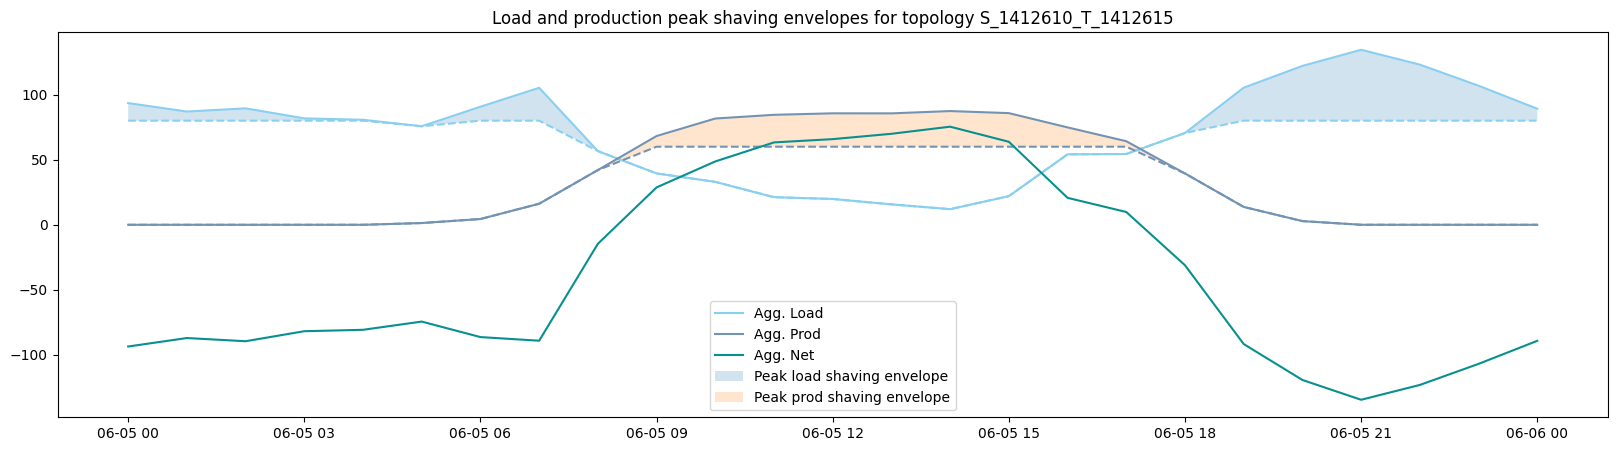

In [58]:
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(df['fromTime'], df['p_load_sum_kwh'], color='#89CFF0', label='Agg. Load')
ax.plot(df['fromTime'], df['req_load_kwh'], color='#89CFF0', linestyle='dashed')
ax.plot(df['fromTime'], df['p_prod_sum_kwh'], color='#7393B3', label='Agg. Prod')
ax.plot(df['fromTime'], df['req_prod_kwh'], color='#7393B3', linestyle='dashed')
ax.plot(df['fromTime'], df['p_export_sum_kwh'], color='#088F8F', label='Agg. Net')
ax.fill_between(df['fromTime'], df['p_load_sum_kwh'], df['req_load_kwh'], alpha=0.2, label='Peak load shaving envelope')
ax.fill_between(df['fromTime'], df['p_prod_sum_kwh'], df['req_prod_kwh'], alpha=0.2, label='Peak prod shaving envelope')
plt.title(f'Load and production peak shaving envelopes for topology {topology}')
ax.legend()

In [59]:
def print_df(df: pl.DataFrame, sort_by: str='ami_cnt', n:int=10):
    with pl.Config() as cfg:
        cfg.set_tbl_cols(-1)
        cfg.set_tbl_width_chars(1000)
        cfg.set_tbl_rows(-1)
        print(df.sort(by=sort_by, descending=True).head(n))
df_envelope=df.select(['fromTime', 'load_env_kwh','prod_env_kwh'])
df_envelope = df_envelope.with_columns((pl.col('fromTime')+timedelta(hours=1)).dt.strftime(time_format).alias('toTime'),
                                        pl.col('fromTime').dt.strftime(time_format),
                                       ).select(['fromTime','toTime','load_env_kwh','prod_env_kwh']).sort(by='fromTime', descending=True)

with open('energy_envelope.json', 'a+') as fp:
    df_envelope.to_pandas().to_json(fp)
print_df(df_envelope, sort_by='fromTime', n=24)

shape: (24, 4)
┌─────────────────────┬─────────────────────┬──────────────┬──────────────┐
│ fromTime            ┆ toTime              ┆ load_env_kwh ┆ prod_env_kwh │
│ ---                 ┆ ---                 ┆ ---          ┆ ---          │
│ str                 ┆ str                 ┆ f64          ┆ f64          │
╞═════════════════════╪═════════════════════╪══════════════╪══════════════╡
│ 2023-06-06T00:00:00 ┆ 2023-06-06T01:00:00 ┆ 9.169569     ┆ 0.0          │
│ 2023-06-05T23:00:00 ┆ 2023-06-06T00:00:00 ┆ 26.867635    ┆ 0.0          │
│ 2023-06-05T22:00:00 ┆ 2023-06-05T23:00:00 ┆ 43.058368    ┆ 0.0          │
│ 2023-06-05T21:00:00 ┆ 2023-06-05T22:00:00 ┆ 54.476684    ┆ 0.0          │
│ 2023-06-05T20:00:00 ┆ 2023-06-05T21:00:00 ┆ 42.074167    ┆ 0.0          │
│ 2023-06-05T19:00:00 ┆ 2023-06-05T20:00:00 ┆ 25.357333    ┆ 0.0          │
│ 2023-06-05T18:00:00 ┆ 2023-06-05T19:00:00 ┆ 0.0          ┆ 0.0          │
│ 2023-06-05T17:00:00 ┆ 2023-06-05T18:00:00 ┆ 0.0          ┆ 4.20754     

In [88]:
with open('energy_envelope.json','w+') as fp:
    json.dump([row for row in df_envelope.iter_rows(named=True)],fp)